In [1]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [1]:
train_data_path = "G:/PARAG_S/A1_part2/data/data/train.json"
test_data_path = "G:/PARAG_S/A1_part2/data/data/test.json"
val_data_path = "G:/PARAG_S/A1_part2/data/data/dev.json"
glove_path = "G:/NLP_assignment_2/glove.6B.100d.txt"


In [2]:

import nltk
import torch.nn.functional as F
from nltk.tokenize import word_tokenize
import json
# nltk.download('punkt')
# Load data from JSON file
# Loading  training_data from JSON file
with open(train_data_path, 'r') as file:
    data = json.load(file)


#loading validation_data from json file
with open(val_data_path, 'r') as file:
    val_data = json.load(file)



#loading test_data from json file
with open(test_data_path, 'r') as file:
    test_data = json.load(file)



# Iterate through each problem
for problem_data in data:
    problem = problem_data["Problem"]
    linear_formula = problem_data["linear_formula"]
    answer = problem_data["answer"]
from transformers import BertTokenizer
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prepare_data_for_bert(data, tokenizer, max_length=256):
   
    input_ids = []
    attention_masks = []

    for item in data:
        encoded_dict = tokenizer.encode_plus(
            item,                      # Problem text to encode.
            add_special_tokens=True,   # Add '[CLS]' and '[SEP]'.
            max_length=max_length,     # Pad & truncate all texts.
            padding='max_length',      # Pad all to max_length.
            truncation=True,           # Truncate to max_length.
            return_attention_mask=True,# Construct attention masks.
            return_tensors='pt',       # Return pytorch tensors.
       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])


    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks



problem_texts = [item["Problem"].lower() for item in data]  
input_ids, attention_masks = prepare_data_for_bert(problem_texts, tokenizer)

val_problem_texts = [item["Problem"].lower() for item in val_data] 
val_input_ids, val_attention_masks = prepare_data_for_bert(val_problem_texts, tokenizer)

test_problem_texts = [item["Problem"].lower() for item in test_data]  
test_input_ids, test_attention_masks = prepare_data_for_bert(test_problem_texts, tokenizer)



for problem_data in data:
    problem = problem_data["Problem"]
    linear_formula = problem_data["linear_formula"]
    answer = problem_data["answer"]



from nltk.tokenize import word_tokenize

import re
from nltk.tokenize import word_tokenize

def tokenize_formula(formula):
    
    parts = formula.split('|')

   
    tokens = ['<sos>']
    for part in parts:
        if part: 
            
            open_parenthesis_index = part.find('(')
            if open_parenthesis_index != -1:
                function = part[:open_parenthesis_index]
                arguments = part[open_parenthesis_index+1:-1]  
                arguments_tokens = arguments.split(',')
                # print(arguments_tokens)
                arguments_token_new=[]
                for tok in arguments_tokens:
                    arguments_token_new.append(tok)
                    arguments_token_new.append(',')
                    
                tokens.extend([function, '('] + arguments_token_new[:-1] + [')'])
            else:
                tokens.append(part)
        if tokens[-1] != '|':
            tokens.append('|')
    tokens.append("<eos>")

    return tokens


from collections import Counter
from nltk.tokenize import word_tokenize

def build_vocab(texts, is_formula=False):
    counter = Counter()
    for text in texts:
        if is_formula:
            tokens = tokenize_formula(text.lower())  
        else:
            tokens = word_tokenize(text.lower())  
        counter.update(tokens)

    
    vocab = {"<pad>": 0, "<unk>": 1, "<sos>": 2, "<eos>":3, "<digit>": 4}


    
    for word in counter:
        if word not in vocab:
            vocab[word] = len(vocab)

    return vocab, counter



import numpy as np
problem_texts = [item["Problem"].lower() for item in data]
linear_formulas = [item["linear_formula"].lower() for item in data]

# Build vocabularies
problem_vocab, _ = build_vocab(problem_texts)
formula_vocab, _ = build_vocab(linear_formulas, is_formula=True)






def text_to_indices(text, vocab):
    tokens = word_tokenize(text.lower()) + ['<eos>']  # Appending <eos> directly
    return [vocab.get(token, vocab["<unk>"]) for token in tokens if not token.isdigit()]


# def text_to_indices(text, vocab):
#     return [vocab.get(token, vocab["<unk>"]) for token in word_tokenize(text.lower()) if not token.isdigit()]
def text_to_indices_formula(text, vocab):
    return [vocab.get(token, vocab["<unk>"]) for token in tokenize_formula(text.lower())]
# def text_to_indices(text, vocab):
#     for token in word_tokenize(text.lower()):
#         if not token.isdigit():
#             return [vocab.get(token, vocab["<unk>"])]




tokenized_problems = [text_to_indices(item["Problem"], problem_vocab) for item in data]
tokenized_formulas = [text_to_indices_formula(item["linear_formula"], formula_vocab) for item in data]
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class MathProblemDataset(Dataset):
    def __init__(self, problems, attention_masks, formulas):
        self.problems = problems
        self.attention_masks = attention_masks
        self.formulas = formulas

    def __len__(self):
        return len(self.problems)

    def __getitem__(self, idx):
        problem = self.problems[idx]
        attention_mask = self.attention_masks[idx]
        formula = torch.tensor(self.formulas[idx], dtype=torch.long)
        return {
            "problem": problem,
            "attention_mask": attention_mask,
            "formula": formula
        }

def collate_fn(batch):
    
    problems = [item["problem"] for item in batch]
    attention_masks = [item["attention_mask"] for item in batch]
    formulas = [item["formula"] for item in batch]

    # Stacking problems and attention
    problems = torch.stack(problems)
    attention_masks = torch.stack(attention_masks)

    # Padding the formulas sequences 
    formulas_padded = pad_sequence(formulas, batch_first=True, padding_value=formula_vocab["<pad>"])

    return {
        "problem": problems,
        "attention_mask": attention_masks,
        "formula": formulas_padded
    }



tokenized_problems = [text_to_indices(item["Problem"], problem_vocab) for item in data]
tokenized_formulas = [text_to_indices_formula(item["linear_formula"], formula_vocab) for item in data]

#tokenizing validation data

tokenized_val_problems = [text_to_indices(item["Problem"], problem_vocab) for item in val_data]
tokenized_val_formulas = [text_to_indices_formula(item["linear_formula"], formula_vocab) for item in val_data]


#tokenizing test data
tokenized_test_problems = [text_to_indices(item["Problem"], problem_vocab) for item in test_data]
tokenized_test_formulas = [text_to_indices_formula(item["linear_formula"], formula_vocab) for item in test_data]


dataset = MathProblemDataset(input_ids, attention_masks, tokenized_formulas)

val_dataset = MathProblemDataset(val_input_ids, val_attention_masks, tokenized_val_formulas)

test_dataset = MathProblemDataset(test_input_ids, test_attention_masks, tokenized_test_formulas)

# Creating DataLoader
data_loader = DataLoader(dataset, batch_size=50 ,shuffle=True, collate_fn=collate_fn)
val_data_loader = DataLoader(val_dataset, batch_size=30, shuffle=True, collate_fn=collate_fn)
test_data_loader = DataLoader(test_dataset, batch_size=30, shuffle=True, collate_fn=collate_fn)


# sample_batch = next(iter(data_loader))
# sample_batch['formula']
# formula_vocab
from transformers import BertModel
import torch.nn as nn
import random

class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        # print(f'enc dim {enc_hid_dim} | dec dim {dec_hid_dim}')
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: [batch size, dec hid dim]


        # print(f'initial hidden {hidden.shape}')
        # print(f'encoder_output {encoder_outputs.shape}')
        # encoder_outputs: [src len, batch size, enc hid dim * 2]
        # encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # print(encoder_outputs.shape)
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        # print(src_len)

        # repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)



        # print(f'inside attention | hidden : {hidden.shape} | encoder_outputs : {encoder_outputs.shape}')
        # print(f'concat {torch.cat((hidden, encoder_outputs), dim=2).shape}')

        # Calculate energy
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        # print(f'energy {energy.shape}')
        attention = self.v(energy).squeeze(2)
        # print(f'attention {attention.shape}')

        return F.softmax(attention, dim=1)


class BERT_Encoder(nn.Module):
    def __init__(self, bert_model_name='bert-base-cased'):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)

        # Freeze BERT parameters to prevent them from being updated during training
        for param in self.bert.parameters():
            param.requires_grad = False
        self.reduce_dim=nn.Linear(768,256)

    def forward(self, input_ids, attention_mask):
        # BERT returns a tuple, where the first element is the last hidden state
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        # last_hidden_state shape: [batch_size, sequence_length, hidden_size]
        # For BERT-base-cased, hidden_size is 768
        # print(f'inside encoder | outputs : {outputs} | last_hidden_state : {last_hidden_state}')
        reduced_state=self.reduce_dim(last_hidden_state)
        return reduced_state


class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention

        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell, encoder_outputs):
        # input = [batch size]
        # hidden = [batch size, dec hid dim]
        # cell = [batch size, dec hid dim]
        # encoder_outputs = [src len, batch size, enc hid dim * 2]
        input = input.unsqueeze(0)  # input = [1, batch size]

        embedded = self.dropout(self.embedding(input))  # embedded = [1, batch size, emb dim]

        # Calculating attention weights and applying to encoder outputs
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)  # a = [batch size, 1, src len]

        encoder_outputs = encoder_outputs  # encoder_outputs = [batch size, src len, enc hid dim * 2]
        # print(f'encoder_outputs {encoder_outputs.shape}')
        weighted = torch.bmm(a, encoder_outputs)  # weighted = [batch size, 1, enc hid dim * 2]
        weighted = weighted.permute(1, 0, 2)  # weighted = [1, batch size, enc hid dim * 2]

        # Combining embedded input word and weighted context, and pass to LSTM
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, (hidden, cell) = self.rnn(rnn_input, (hidden.unsqueeze(0), cell.unsqueeze(0)))

       
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))

        return prediction, hidden.squeeze(0), cell.squeeze(0), a.squeeze(1)


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device,  bert_output_dim=256, dec_hid_dim=256):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        # Initializing hidden and cell state transformation layers
        self.fc_hidden = nn.Linear(bert_output_dim,dec_hid_dim)
        self.fc_cell = nn.Linear(bert_output_dim, dec_hid_dim)

    def forward(self, input_ids, attention_mask, trg, teacher_forcing_ratio=0.6):
        # input_ids = [batch size, src len]
        # trg = [batch size, trg len]
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim

        # tensor to store decoder outputs
        outputs = torch.zeros(trg_len-1, batch_size, trg_vocab_size).to(self.device)

        # last hidden state of the encoder is used as the initial hidden state of the decoder
        encoder_outputs = self.encoder(input_ids, attention_mask)

       
        hidden = torch.tanh(self.fc_hidden(encoder_outputs[:, 0]))
        cell = torch.tanh(self.fc_cell(encoder_outputs[:, 0]))

        # first input to the decoder is the <sos> tokens
        input = trg[:, 0]

        for t in range(0, trg_len-1):
            output, hidden, cell, _ = self.decoder(input, hidden, cell, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[:, t+1] if teacher_force else top1

        return outputs

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


DEC_EMB_DIM = 100  # Embedding dimension for decoder
ENC_HID_DIM = 128  # Hidden dimension for encoder
DEC_HID_DIM = 256  # Hidden dimension for decoder (
# ENC_DROPOUT = 0.5  # Dropout rate for encoder
DEC_DROPOUT = 0.5  # Dropout rate for decoder
OUTPUT_DIM = len(formula_vocab)
# Assuming your LSTM decoder is defined as `decoder`
encoder = BERT_Encoder().to(device)
attention = Attention(ENC_HID_DIM, DEC_HID_DIM)

decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attention)
model = Seq2Seq(encoder, decoder, device).to(device)

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from tqdm.auto import tqdm
from transformers import AdamW



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder_params = list(model.encoder.bert.named_parameters())
other_params = [p for n, p in model.named_parameters() if not n.startswith('encoder.bert')]

learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)


PAD_IDX = formula_vocab["<pad>"] 
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX).to(device)

# # Define a training function
# def train(model, iterator, optimizer, criterion, clip):
#     model.train()  # Set the model to training mode
#     epoch_loss = 0

#     for i, batch in enumerate(tqdm(iterator)):
#         input_ids = batch['problem'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         trg = batch['formula'].to(device)
#         # print(f'target {trg}')

#         # Adjust target tensor to fit expected output structure, shifting it by one to ignore <sos> token for loss calculation
#         trg_input = trg
#         trg_output = trg[:, 1:]
#         # trg_new = trg[:, 1:]
#         # print(f'trg_out : {trg_output.shape}')
#         # print(f'trg_output : {trg_output}')

#         optimizer.zero_grad()  # Clear any previously calculated gradients

#         output = model(input_ids, attention_mask, trg_input)
#         # print(f'output {output.shape}')

#         # Reshape output and target tensors to compute loss
#         output_dim = output.shape[-1]
#         # output = output.contiguous().view(-1, output_dim)
#         # trg_output = trg_output.contiguous().view(-1)
#         output=output.permute(1,2,0)
#         # Calculate loss
#         loss = criterion(output, trg_output)
#         loss.backward()  # Backpropagate the loss

#         torch.nn.utils.clip_grad_norm_(model.parameters(), clip)  # Gradient clipping

#         optimizer.step()  # Update model parameters

#         epoch_loss += loss.item()

#     return epoch_loss / len(iterator)


def train(model, iterator, optimizer, criterion, clip):
    model.train()  # Set the model to training mode
    epoch_loss = 0
    optimizer.zero_grad()  # Clear gradients at the beginning of each epoch

    for i, batch in enumerate(tqdm(iterator)):
        input_ids = batch['problem'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        trg = batch['formula'].to(device)

        # Adjusting target tensor to fit expected output structure, shifting it by one to ignore <sos> token for loss calculation
        trg_input = trg
        trg_output = trg[:, 1:]

        output = model(input_ids, attention_mask, trg_input)

        # Reshaping output and target tensors to compute loss
        output = output.permute(1, 2, 0)
        output_dim = output.shape[-1]

        # Calculating loss
        loss = criterion(output, trg_output)
        epoch_loss += loss.item()

        # Backpropagation
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        
        optimizer.step()
        

    return epoch_loss / len(iterator)


import torch
from tqdm import tqdm

def evaluate(model, iterator, criterion):
    model.eval()  
    epoch_loss = 0

    with torch.no_grad():
        for batch in tqdm(iterator):
            input_ids = batch['problem'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            trg = batch['formula'].to(device)

            # shifting it by one to ignore <sos> token for loss calculation
            trg_input = trg
            trg_output = trg[:, 1:]

            output = model(input_ids, attention_mask, trg_input)

            # Reshape output and target tensors to compute loss
            output = output.permute(1, 2, 0)
            output_dim = output.shape[-1]

            # Calculate loss
            loss = criterion(output, trg_output)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

c:\Users\ANAND\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
len(formula_vocab)

145

In [5]:


def save_checkpoint(model, optimizer, train_losses, val_losses, epoch, checkpoint_path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    torch.save(checkpoint, checkpoint_path)

# Example usage:
clip = 1  # Gradient clipping value
num_epochs = 50  # Number of epochs to train
best_val_loss = float('inf')
checkpoint_path = '/kaggle/working//model_BERT_checkpoint.pt'


clip = 1  # Gradient clipping value
num_epochs = 50  # Number of epochs to train

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = train(model, data_loader, optimizer, criterion, clip)
    val_loss = evaluate(model, val_data_loader, criterion)
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_checkpoint(model, optimizer, train_losses, val_losses, epoch, checkpoint_path)

torch.save(model.state_dict(), '/kaggle/working/final_model_BERT.pt')


# for epoch in range(num_epochs):
#     train_loss = train(model, data_loader, optimizer, criterion, clip)
#     val_loss = evaluate(model, val_data_loader, criterion)
#     print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

#     train_losses.append(train_loss)
#     val_losses.append(val_loss)

#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         save_checkpoint(model, optimizer, train_losses, val_losses, epoch, checkpoint_path)


100%|██████████| 99/99 [00:28<00:00,  3.43it/s]


Epoch: 1, Train Loss: 1.1590, Val Loss: 0.8993


100%|██████████| 99/99 [00:28<00:00,  3.44it/s]


Epoch: 2, Train Loss: 0.8966, Val Loss: 0.8716


100%|██████████| 99/99 [00:28<00:00,  3.44it/s]


Epoch: 3, Train Loss: 0.8542, Val Loss: 0.8447


100%|██████████| 99/99 [00:28<00:00,  3.45it/s]


Epoch: 4, Train Loss: 0.8297, Val Loss: 0.8114


100%|██████████| 99/99 [00:28<00:00,  3.45it/s]


Epoch: 5, Train Loss: 0.8191, Val Loss: 0.8093


100%|██████████| 99/99 [00:28<00:00,  3.46it/s]


Epoch: 6, Train Loss: 0.8082, Val Loss: 0.7799


100%|██████████| 99/99 [00:28<00:00,  3.45it/s]


Epoch: 7, Train Loss: 0.7873, Val Loss: 0.7730


100%|██████████| 99/99 [00:28<00:00,  3.44it/s]


Epoch: 8, Train Loss: 0.7849, Val Loss: 0.7804


100%|██████████| 99/99 [00:28<00:00,  3.45it/s]


Epoch: 9, Train Loss: 0.7711, Val Loss: 0.7549


100%|██████████| 99/99 [00:28<00:00,  3.43it/s]


Epoch: 10, Train Loss: 0.7600, Val Loss: 0.7636


100%|██████████| 99/99 [00:28<00:00,  3.45it/s]


Epoch: 11, Train Loss: 0.7560, Val Loss: 0.7547


100%|██████████| 99/99 [00:28<00:00,  3.44it/s]


Epoch: 12, Train Loss: 0.7466, Val Loss: 0.7575


100%|██████████| 99/99 [00:28<00:00,  3.43it/s]


Epoch: 13, Train Loss: 0.7400, Val Loss: 0.7263


100%|██████████| 99/99 [00:28<00:00,  3.45it/s]


Epoch: 14, Train Loss: 0.7319, Val Loss: 0.7220


100%|██████████| 99/99 [00:28<00:00,  3.44it/s]


Epoch: 15, Train Loss: 0.7229, Val Loss: 0.7243


100%|██████████| 99/99 [00:28<00:00,  3.45it/s]


Epoch: 16, Train Loss: 0.7177, Val Loss: 0.7296


100%|██████████| 99/99 [00:28<00:00,  3.44it/s]


Epoch: 17, Train Loss: 0.7089, Val Loss: 0.7206


100%|██████████| 99/99 [00:28<00:00,  3.44it/s]


Epoch: 18, Train Loss: 0.7059, Val Loss: 0.7031


100%|██████████| 99/99 [00:28<00:00,  3.45it/s]


Epoch: 19, Train Loss: 0.6936, Val Loss: 0.6873


100%|██████████| 99/99 [00:28<00:00,  3.44it/s]


Epoch: 20, Train Loss: 0.6881, Val Loss: 0.6849


100%|██████████| 99/99 [00:28<00:00,  3.46it/s]


Epoch: 21, Train Loss: 0.6877, Val Loss: 0.7079


100%|██████████| 99/99 [00:28<00:00,  3.44it/s]


Epoch: 22, Train Loss: 0.6749, Val Loss: 0.6767


100%|██████████| 99/99 [00:28<00:00,  3.44it/s]


Epoch: 23, Train Loss: 0.6717, Val Loss: 0.6688


100%|██████████| 99/99 [00:28<00:00,  3.44it/s]


Epoch: 24, Train Loss: 0.6606, Val Loss: 0.6663


100%|██████████| 99/99 [00:28<00:00,  3.45it/s]


Epoch: 25, Train Loss: 0.6615, Val Loss: 0.6468


100%|██████████| 99/99 [00:28<00:00,  3.45it/s]


Epoch: 26, Train Loss: 0.6516, Val Loss: 0.6505


100%|██████████| 99/99 [00:28<00:00,  3.44it/s]


Epoch: 27, Train Loss: 0.6494, Val Loss: 0.6649


100%|██████████| 99/99 [00:28<00:00,  3.44it/s]


Epoch: 28, Train Loss: 0.6457, Val Loss: 0.6506


100%|██████████| 99/99 [00:28<00:00,  3.45it/s]


Epoch: 29, Train Loss: 0.6391, Val Loss: 0.6662


100%|██████████| 99/99 [00:28<00:00,  3.44it/s]


Epoch: 30, Train Loss: 0.6341, Val Loss: 0.6289


100%|██████████| 99/99 [00:28<00:00,  3.44it/s]


Epoch: 31, Train Loss: 0.6268, Val Loss: 0.6212


100%|██████████| 99/99 [00:28<00:00,  3.44it/s]


Epoch: 32, Train Loss: 0.6205, Val Loss: 0.6334


100%|██████████| 99/99 [00:28<00:00,  3.44it/s]


Epoch: 33, Train Loss: 0.6156, Val Loss: 0.6329


100%|██████████| 99/99 [00:28<00:00,  3.45it/s]


Epoch: 34, Train Loss: 0.6141, Val Loss: 0.6407


100%|██████████| 99/99 [00:28<00:00,  3.46it/s]


Epoch: 35, Train Loss: 0.6125, Val Loss: 0.6257


100%|██████████| 99/99 [00:28<00:00,  3.45it/s]


Epoch: 36, Train Loss: 0.6084, Val Loss: 0.6091


100%|██████████| 99/99 [00:28<00:00,  3.45it/s]


Epoch: 37, Train Loss: 0.6038, Val Loss: 0.6075


100%|██████████| 99/99 [00:28<00:00,  3.46it/s]


Epoch: 38, Train Loss: 0.6035, Val Loss: 0.6228


100%|██████████| 99/99 [00:28<00:00,  3.45it/s]


Epoch: 39, Train Loss: 0.5925, Val Loss: 0.6031


100%|██████████| 99/99 [00:28<00:00,  3.46it/s]


Epoch: 40, Train Loss: 0.5881, Val Loss: 0.6123


100%|██████████| 99/99 [00:28<00:00,  3.46it/s]


Epoch: 41, Train Loss: 0.5895, Val Loss: 0.5969


100%|██████████| 99/99 [00:28<00:00,  3.45it/s]


Epoch: 42, Train Loss: 0.5832, Val Loss: 0.5963


100%|██████████| 99/99 [00:28<00:00,  3.46it/s]


Epoch: 43, Train Loss: 0.5800, Val Loss: 0.6011


100%|██████████| 99/99 [00:28<00:00,  3.45it/s]


Epoch: 44, Train Loss: 0.5715, Val Loss: 0.5921


100%|██████████| 99/99 [00:28<00:00,  3.46it/s]


Epoch: 45, Train Loss: 0.5721, Val Loss: 0.5825


100%|██████████| 99/99 [00:28<00:00,  3.46it/s]


Epoch: 46, Train Loss: 0.5714, Val Loss: 0.6006


100%|██████████| 99/99 [00:28<00:00,  3.47it/s]


Epoch: 47, Train Loss: 0.5671, Val Loss: 0.5746


100%|██████████| 99/99 [00:28<00:00,  3.46it/s]


Epoch: 48, Train Loss: 0.5637, Val Loss: 0.5837


100%|██████████| 99/99 [00:28<00:00,  3.46it/s]


Epoch: 49, Train Loss: 0.5622, Val Loss: 0.5849


100%|██████████| 99/99 [00:28<00:00,  3.46it/s]


Epoch: 50, Train Loss: 0.5600, Val Loss: 0.5802


In [6]:
loss_data = {
    'train_losses': train_losses,
    'valid_losses': val_losses
}

with open('/kaggle/working/loss_data_model_BERT.json', 'w') as f:
    json.dump(loss_data, f)


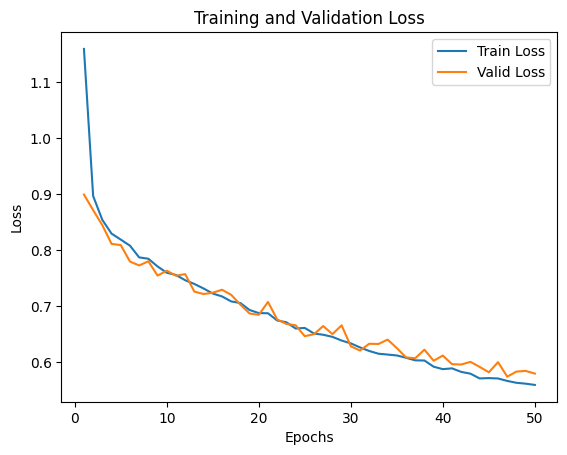

In [7]:
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()


In [8]:





import torch
import torch.nn.functional as F
from transformers import BertTokenizer


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

class BeamSearchNode(object):
    def __init__(self, hidden, previousNode, wordId, logProb, length):
        self.hidden = hidden
        self.prevNode = previousNode
        self.wordid = wordId
        self.logp = logProb
        self.length = length

    def eval(self, alpha=1.0):
        reward = 0
        
        return self.logp / float(self.length - 1 + 1e-6) + alpha * reward

def beam_search(model, input_ids, attention_mask, beam_width=10, max_len=50):
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    with torch.no_grad():
        encoder_outputs = model.encoder(input_ids, attention_mask=attention_mask)
        # Initializing decoder's hidden and cell states from BERT's [CLS] token output
        hidden = torch.tanh(model.fc_hidden(encoder_outputs[:, 0]))
        cell = torch.tanh(model.fc_cell(encoder_outputs[:, 0]))

    start_node = BeamSearchNode((hidden, cell), None, formula_vocab["<sos>"], 0, 1)
    nodes = [start_node]

    # Beam search loop
    for _ in range(max_len):
        new_nodes = []
        for node in nodes:
            input = torch.LongTensor([node.wordid]).to(device)
            hidden, cell = node.hidden

            with torch.no_grad():
                
                output, hidden, cell, _ = model.decoder(input, hidden, cell, encoder_outputs)
                log_probs = F.log_softmax(output, dim=1)

            top_log_probs, top_idx = log_probs.topk(beam_width)
            for i in range(beam_width):
                word_idx = top_idx[0][i].item()
                log_prob = top_log_probs[0][i].item()

                new_node = BeamSearchNode((hidden, cell), node, word_idx, node.logp + log_prob, node.length + 1)
                new_nodes.append(new_node)

        # Sorting nodes by score
        nodes = sorted(new_nodes, key=lambda node: node.eval(), reverse=True)[:beam_width]

    # Retrieving the highest scoring end node
    end_node = nodes[0]
    output_sequence = [end_node.wordid]

    # Tracing back through parents to construct the full output sequence
    while end_node.prevNode:
        end_node = end_node.prevNode
        output_sequence.append(end_node.wordid)

    output_sequence = output_sequence[::-1]  # Reversing to get correct order

    
    output_tokens = []
    for i in output_sequence:
        if i == formula_vocab["<eos>"]:  
            break
        elif i == formula_vocab["<sos>"]:
            continue
        else:
            output_tokens.append(list(formula_vocab.keys())[list(formula_vocab.values()).index(i)])

    return output_tokens




problem_text ="find the compound interest on $ 1200 for 6 years at 20 % p . a . if ci is component yearly ?"
encoded_input = tokenizer.encode_plus(problem_text, return_tensors='pt', max_length=256, padding='max_length', truncation=True)
input_ids = encoded_input['input_ids']
attention_mask = encoded_input['attention_mask']


output_tokens = beam_search(model, input_ids, attention_mask)

string_out = ''
for tok in output_tokens :
    string_out += tok
print(string_out)


divide(n0,const_100)|add(#0,n1)|


In [4]:
checkpoint_path = "G:/final_part_2/lstm_bert_frozen/model_BERT_checkpoint.pt"

# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location='cpu')  # or 'cuda' if you're using GPU

# Extract the model's state dictionary from the checkpoint
model_state_dict = checkpoint['model_state_dict']

# Load the model state dictionary into your model
model.load_state_dict(model_state_dict)

# Make sure to call model.eval() if you're in inference mode
model.eval()

Seq2Seq(
  (encoder): BERT_Encoder(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(28996, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
          

In [ ]:
# Load the model
# model= torch.load('/content/drive/MyDrive/Colab_Notebooks/final_model.pt')
# model = model.to(device)
# import torch

model = model.to(device)  




for entry in val_data:
   
    problem_text = entry["Problem"] 

    # tokenized_problems = [text_to_indices(item["Problem"], problem_vocab) for item in data]

    encoded_input = tokenizer.encode_plus(problem_text, return_tensors='pt', max_length=256, padding='max_length', truncation=True)
    input_ids = encoded_input['input_ids']
    attention_mask = encoded_input['attention_mask']

    # Beam search with BERT model
    output_tokens = beam_search(model, input_ids, attention_mask, beam_width=10,max_len=80)

    string_out=""
    for tok in output_tokens:
      string_out+=tok
    entry["predicted"] = string_out

    with open('validation_predictions_BERT_BEAM_1.json', 'w') as f_out:
        json.dump(val_data, f_out, indent=4)  

In [ ]:
# Load the model
# model= torch.load('/content/drive/MyDrive/Colab_Notebooks/final_model.pt')
# model = model.to(device)
# import torch

model = model.to(device)  # Move the model to the appropriate device


for entry in test_data:
    
    problem_text = entry["Problem"]  

    # tokenized_problems = [text_to_indices(item["Problem"], problem_vocab) for item in data]

    encoded_input = tokenizer.encode_plus(problem_text, return_tensors='pt', max_length=256, padding='max_length', truncation=True)
    input_ids = encoded_input['input_ids']
    attention_mask = encoded_input['attention_mask']

    # Beam search with BERT model
    output_tokens = beam_search(model, input_ids, attention_mask, beam_width=1,max_len=80)

    str=""
    for tok in output_tokens:
      str+=tok
    entry["predicted"] = str

    with open('test_predictions_BERT_BEAM_1.json', 'w') as f_out:
        json.dump(test_data, f_out, indent=4)  

In [ ]:
# Load the model
# model= torch.load('/content/drive/MyDrive/Colab_Notebooks/final_model.pt')
# model = model.to(device)
# import torch

model = model.to(device) 
for entry in test_data:
    
    problem_text = entry["Problem"]  

    # tokenized_problems = [text_to_indices(item["Problem"], problem_vocab) for item in data]

    encoded_input = tokenizer.encode_plus(problem_text, return_tensors='pt', max_length=256, padding='max_length', truncation=True)
    input_ids = encoded_input['input_ids']
    attention_mask = encoded_input['attention_mask']

    # Beam search with BERT model
    output_tokens = beam_search(model, input_ids, attention_mask, beam_width=10,max_len=80)

    str=""
    for tok in output_tokens:
      str+=tok
    entry["predicted"] = str

    with open('test_predictions_BERT_BEAM_10.json', 'w') as f_out:
        json.dump(test_data, f_out, indent=4)  

In [ ]:


model = model.to(device)  


for entry in test_data:
  
    problem_text = entry["Problem"]  # This might need processing depending on your model's input format

    # tokenized_problems = [text_to_indices(item["Problem"], problem_vocab) for item in data]

    encoded_input = tokenizer.encode_plus(problem_text, return_tensors='pt', max_length=256, padding='max_length', truncation=True)
    input_ids = encoded_input['input_ids']
    attention_mask = encoded_input['attention_mask']

    # Beam search with BERT model
    output_tokens = beam_search(model, input_ids, attention_mask, beam_width=20,max_len=80)

    str=""
    for tok in output_tokens:
      str+=tok
    entry["predicted"] = str

    with open('/content/drive/MyDrive/DL_part_2/test_predictions_BERT_BEAM_20.json', 'w') as f_out:
        json.dump(test_data, f_out, indent=4) 